In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
# import seaborn as sns
import re
import nltk
from sklearn import ensemble
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import gutenberg, stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
lmtzr= WordNetLemmatizer()
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
%matplotlib inline

In [2]:
my_stopwords = stopwords.words('english')
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub(r"'",' ',text)
    text = re.sub(r'"',' ',text)
    text = re.sub("[\[].*?[\]]", ' ', text)
    text = ' '.join(text.split()).lower()
    return text

In [3]:
text_list =['austen-sense.txt', 'shakespeare-hamlet.txt',\
            'milton-paradise.txt','whitman-leaves.txt']

author_list = []
for text in text_list: 
    author = text.split('-')[0]
    author_list.append(author)
author_list

['austen', 'shakespeare', 'milton', 'whitman']

In [4]:
books = []
for i in range(len(text_list)):
    file_name = text_list[i]
    books_of_paragraphs = gutenberg.paras(file_name)
    clean_paragraph = []
    for paragraph in books_of_paragraphs:
        
        para = paragraph[0]
        sentence_as_string = ' '.join(para)
        sentence_as_string = text_cleaner(sentence_as_string).lower()

        clean_paragraph.append(sentence_as_string)
    books.append(clean_paragraph)

In [5]:
def all_the_good_stuff(tokenized_texts, include_stop=False):
    new_txt=[]
    for paragraph in tokenized_texts: 
        list_of_tokens = word_tokenize(paragraph)
        processed_texts = []
        for token in list_of_tokens: 
            if (token not in my_stopwords or include_stop) and (token not in string.punctuation): 
                processed_texts.append(token)
               
        if len(processed_texts) > 3:
            new_txt.append(" ".join(processed_texts))
    return new_txt

In [6]:
df = pd.DataFrame()
for book, author in zip(books, author_list):

    book = all_the_good_stuff(book, include_stop = False)
    book = [[paragraph, author] for paragraph in book]
    book = pd.DataFrame(book, columns = ['text','author'])
    df = df.append(book, ignore_index = True)

In [7]:
df.head()

,text,author
0,family dashwood long settled sussex,austen
1,former marriage mr henry dashwood one son pres...,austen
2,old gentleman died read like almost every gave...,austen
3,mr dashwood disappointment first severe temper...,austen
4,son sent soon danger known mr dashwood recomme...,austen


In [8]:
X = df['text']
Y = df['author']

X_train, X_test = train_test_split(X, test_size=0.25, random_state=12)

vectorizer = TfidfVectorizer(max_df=0.6, # drop words that occur in more than 60% of paragraphs
                             min_df=5,  # Words appear at least 5x
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True #Prevents divide-by-zero errors
                            )

#Applying the vectorizer
para_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % para_tfidf.get_shape()[1])

X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(para_tfidf, 
                                                                Y,
                                                                test_size=0.25,
                                                                random_state=12)

Number of features: 2462


In [9]:
i_holder = []
variances = []
for i in range(100,500,25):
    svd= TruncatedSVD(i)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    # Run SVD on the training data, then project the training data.
    X_train_lsa = lsa.fit_transform(X_train_tfidf)
    #creating test lsa group for later
    X_test_lsa = lsa.transform(X_test_tfidf)

    variance_explained=svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    i_holder.append(i)
    variances.append(total_variance)

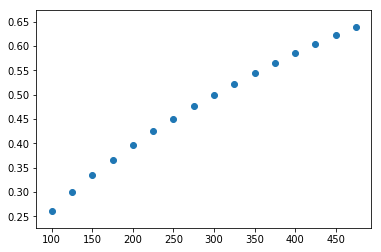

In [10]:
plt.scatter(i_holder,variances)

In [11]:
# Chose 300 mostly do to the strength of my machine
svd= TruncatedSVD(300)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
#creating test lsa group for later
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 49.978433734


In [14]:
# Chose 4 clusters due to 4 authors
k_mean = KMeans(n_clusters=4, random_state=12)
k_mean.fit(X_train_lsa)
Y_pred = k_mean.predict(X_train_lsa)

In [15]:
print(pd.crosstab(Y_train.values, Y_pred))

col_0          0    1     2    3
row_0                           
austen        13  166   238  634
milton         2    0     6    0
shakespeare    1    0    22    0
whitman      145    8  1234    3


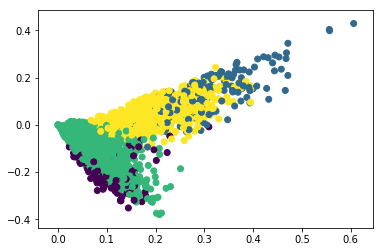

In [16]:
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=Y_pred)
plt.show()

In [24]:
#Looking at what sorts of paragraphs our solution considers similar, for the first 10 components
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(4):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
text
marianne steadfast ever see said elinor altered                                                      0.606203
marianne shyness excuse inattention said elinor                                                      0.556727
boast however said elinor injustice                                                                  0.556240
many many circumstances said elinor solemnly                                                         0.471383
know said mrs dashwood                                                                               0.471278
well sir said mrs                                                                                    0.468443
elinor frightened away dislike mrs jennings said marianne least need prevent accepting invitation    0.467551
think like said elinor know                                                                          0.465994
well marianne said elinor soon left one morning think done pretty well                               0

In [26]:
cluster_df = pd.DataFrame({'para':X_train, 'cluster':Y_pred})
for clust in np.arange(0,4,1):
    print(cluster_df[cluster_df['cluster'] == clust].head(10))

      cluster                                               para
1552        0  stop day night shall possess origin poems shal...
3151        0  untold want life land ne er granted voyager sa...
2934        0  soul always beautiful universe duly order ever...
1828        0  tire give burdens rest chuff hand hip due time...
2853        0  along history slopes rivulet running sinking s...
2057        0  young man comes bearing message brother shall ...
776         0  shall brief quitted barton last october give i...
2100        0  live ruler life slave meet life powerful conqu...
3024        0  yet thou living present brain heir dead old wo...
3252        0  somehow let go yet funeral though let remain b...
      cluster                                               para
337         1  puzzled spend large fortune said mrs dashwood ...
103         1  talked flannel waistcoats said marianne flanne...
1256        1  weather settled recovered strength said take l...
155         1  perhaps sa

In [27]:
vectorizer_bow = TfidfVectorizer(max_df=0.6,
                             min_df=5, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=False,
                             norm=u'l2',
                             smooth_idf=True
                            )

sentence_bow= vectorizer_bow.fit_transform(X)


X_train_bow, X_test_bow, Y_train, Y_test = train_test_split(sentence_bow, 
                                                                Y,
                                                                test_size=0.25,
                                                                random_state=1217)

In [28]:
def test_metrics(model, x, y):
    y_pred = model.predict(x)
    accuracy = accuracy_score(y, y_pred)
    macro = f1_score(y, y_pred, average='macro')
    micro = f1_score(y, y_pred, average='micro')
    weighted = f1_score(y, y_pred, average='weighted')
    print(model)
    print('Accuracy:', accuracy)
    print('F1 Macro:', macro)
    print('F1 Micro:', micro)
    print('F1 Weighted:', weighted)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

rfc = ensemble.RandomForestClassifier()
logistic = LogisticRegression()
gbc = ensemble.GradientBoostingClassifier()

In [33]:
rfc_tfidf = rfc.fit(X_train_tfidf, Y_train)
test_metrics(rfc_tfidf, X_test_tfidf, Y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy: 0.520631067961
F1 Macro: 0.248952827053
F1 Micro: 0.520631067961
F1 Weighted: 0.511741444166


/Users/joshuarkarnad/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
rfc_bow = rfc.fit(X_train_bow,Y_train)
test_metrics(rfc_bow, X_test_bow, Y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy: 0.928398058252
F1 Macro: 0.521704759139
F1 Micro: 0.928398058252
F1 Weighted: 0.925170541221


/Users/joshuarkarnad/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
gbc_tfidf = gbc.fit(X_train_tfidf, Y_train)
test_metrics(gbc_tfidf, X_test_tfidf, Y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Accuracy: 0.56067961165
F1 Macro: 0.232333236021
F1 Micro: 0.56067961165
F1 Weighted: 0.49845609588


In [36]:
gbc_bow = gbc.fit(X_train_bow, Y_train)
test_metrics(gbc_bow, X_test_bow, Y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Accuracy: 0.894417475728
F1 Macro: 0.50286358733
F1 Micro: 0.894417475728
F1 Weighted: 0.890155299817
